# Общая информация
__Цель:__ сравнить качество генерируемых ответов, посмотреть зависимостри результатов генерации от различных свойств вопроса

__Задачи:__

1) Посмотреть руками примеры генерации ответов

2) Сравнить средние метрики базовой и тюниной модели

3) Посмотреть распределение длин генерируемых ответов

4) Посмотреть корреляцию длины генерируемого ответа и длины вопроса

5) Сделать выводы

In [1]:
import json
import os
import pickle
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

import torch
from nltk import SnowballStemmer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, random_split
from tqdm.auto import tqdm


warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)

In [2]:
def add_answers_length(df):
    df['len_of_generated_answer'] = df.generated_answer.apply(lambda x: len(x.split(" ")))
    
    df['len_of_original_answer'] = df.original_answer.apply(lambda x: len(x.split(" ")))
    
    return df

In [3]:
def get_metrics(df, df_diff, df1_name, df2_name, print_1=True, print_2=True):
    bert_f1 = df.bert_f1.mean()
    rouge_score = df.rouge_score.mean()
    bleu_score = df.bleu_score.mean()

    t_bert_f1 = df_diff.bert_f1.mean()
    t_rouge_score = df_diff.rouge_score.mean()
    t_bleu_score = df_diff.bleu_score.mean()

    if print_1:
        print(
            f"BERT score {df1_name}: {round(bert_f1, 5)}",
            f"ROUGE score {df1_name}: {round(rouge_score, 5)}",
            f"Unigram BLEU score {df1_name}: {round(bleu_score, 5)}",
            sep="\n",
        )

        print()

    if print_2:

        print(
            f"BERT score {df2_name}: {round(t_bert_f1, 5)}",
            f"ROUGE score {df2_name}: {round(t_rouge_score, 5)}",
            f"Unigram BLEU score {df2_name}: {round(t_bleu_score, 5)}",
            sep="\n",
        )

        print()

    print(
        f"BERT score diff: {t_bert_f1 - bert_f1} ({round((t_bert_f1 - bert_f1)/bert_f1*100, 2)} %)",
        f"ROUGE score diff: {t_rouge_score - rouge_score} ({round((t_rouge_score - rouge_score)/rouge_score*100, 2)} %)",
        f"Unigram BLEU score diff: {t_bleu_score - bleu_score} ({round((t_bleu_score - bleu_score)/bleu_score*100, 2)} %)",
        sep="\n",
    )

    return {
        df1_name: {
            "bert": bert_f1,
            "rouge": rouge_score,
            "bleu": bleu_score,
        },
        df2_name: {
            "bert": t_bert_f1,
            "rouge": t_rouge_score,
            "bleu": t_bleu_score,
        },
    }

# Фиксация сидов

In [4]:
torch.manual_seed(42)
np.random.seed(42)

## Загрузка таблиц

In [5]:
data_dir = r"D:/vkr/Notebooks/Analys/artifacts/first_base_tuning_camparision_python/"

In [6]:
base_eval_table = pd.read_csv(data_dir+'base_eval_python.csv')

tuned_eval_table = pd.read_csv(data_dir+'tuned_eval_python.csv')
tuned_eval_table_200 = pd.read_csv(data_dir+'tuned_eval_python_200_length.csv')
tuned_eval_table_100 = pd.read_csv(data_dir+'tuned_eval_python_100_length.csv')

# Анализ результатов

## Изучение семплов

In [7]:
import random

In [8]:
random_idx = random.randrange(0, len(base_eval_table))

In [9]:
pd.DataFrame(base_eval_table.iloc[random_idx])

,55
title,Python change Windows Path refresh Shell
question,"i have a Python script here and it is called from the Windows CMD. It is executing some commands and also changing the Windows environment variables. Now after i changed them with the command ""setx"". I have to restart another Shell so the new variables are loaded into it. Is it possible that the main shell from which i called my script can update the variables itself ?Or is it possible to start another shell with the new variables and the script will continue in the new opened shell ?Thanks"
generated_answer,"ou can use the following command to change the environment variable: \nsetenv -i <variable> <new value>\n\nThe <var> is the variable name and <value> the value to be set.\nFor example: setenv ""PATH"" ""C:\Program Files\Python27\bin;C:\\ProgramData\\Oracle\\Middleware\\Java\\bin""\nThis will set the PATH variable to the path of the Java executable.\n\n"
original_answer,"Each process has its own environment. When a process starts another process, the new process gets a eventually modified copy of its parent environment.The rule is :a process can modify its own environment - this modifications will be inherited by child processes started latera process can modify at start time the environment of its child processesa process can never modify its parent's environment *So when you start a Python script from a cmd.exe :the script can change its own environment and those changes will be visible by all subsequent commands of the script and all its childrenthe script cannot change the environment for its parent cmd.exe nor for subsequent commands of that cmd.exeIf you need to execute other batch commands after changing the environment, you will have to start a new cmd.exe for the python script and have this new shell execute the other commands, or directly execute a .bat file both via subprocessmodule.setx is a completely different thing : it updates the default environmnent that is given to processes started from windows explorer including cmd.exe. That environment is stored permanently in Windows registry, and every change to it is broadcasted to all active processes ... that monitors it. Any windows GUI application can process it and explorer does - that's how every explorer window know immediatly what is the current default environment, but console applications normaly do not.* well it used to be possible for .com executable in old MS/DOS system and was even documented. It should be possible on Windows recent system through WriteProcessMemory API call but is absolutely non documented thanks to eryksun for noticing"
bert_precision,0.785083
bert_recall,0.798375
bert_f1,0.791673
rouge_score,0.114804
bleu_score,0.093294


In [10]:
pd.DataFrame(tuned_eval_table.iloc[random_idx])

,55
title,Python change Windows Path refresh Shell
question,"i have a Python script here and it is called from the Windows CMD. It is executing some commands and also changing the Windows environment variables. Now after i changed them with the command ""setx"". I have to restart another Shell so the new variables are loaded into it. Is it possible that the main shell from which i called my script can update the variables itself ?Or is it possible to start another shell with the new variables and the script will continue in the new opened shell ?Thanks"
generated_answer,"u can't change the environment of a running process. You can, however, change its environment, and then start a new process with that environment."
original_answer,"Each process has its own environment. When a process starts another process, the new process gets a eventually modified copy of its parent environment.The rule is :a process can modify its own environment - this modifications will be inherited by child processes started latera process can modify at start time the environment of its child processesa process can never modify its parent's environment *So when you start a Python script from a cmd.exe :the script can change its own environment and those changes will be visible by all subsequent commands of the script and all its childrenthe script cannot change the environment for its parent cmd.exe nor for subsequent commands of that cmd.exeIf you need to execute other batch commands after changing the environment, you will have to start a new cmd.exe for the python script and have this new shell execute the other commands, or directly execute a .bat file both via subprocessmodule.setx is a completely different thing : it updates the default environmnent that is given to processes started from windows explorer including cmd.exe. That environment is stored permanently in Windows registry, and every change to it is broadcasted to all active processes ... that monitors it. Any windows GUI application can process it and explorer does - that's how every explorer window know immediatly what is the current default environment, but console applications normaly do not.* well it used to be possible for .com executable in old MS/DOS system and was even documented. It should be possible on Windows recent system through WriteProcessMemory API call but is absolutely non documented thanks to eryksun for noticing"
bert_precision,0.893569
bert_recall,0.80713
bert_f1,0.848153
rouge_score,0.113712
bleu_score,0.150685


In [11]:
pd.DataFrame(tuned_eval_table_200.iloc[random_idx])

,55
title,How to write tests for writers / parsers? Python
question,"I have written a piece of software in Python that does a lot of parsing and a lot of writing files to disk. I am starting to write unit tests, but have no idea how to unit test a function that just writes some data to disk, and returns nothing.I am familiar with unittest and ddt. Any advice or even a link to a resource where I could learn more would be appreciated."
generated_answer,"I think you're going to have to use a mocking library. The Python standard library has a number of mocking libraries, including mock, which is the one you want."
original_answer,"Arguably, the best solution is to split your function into two pieces. One piece to do the parsing, the second to do the writing. Then, you can unit test each piece separately. For the first piece, give it a file and verify the parsing function returns the proper string, and/or throws the proper exception. For the second, give it a string to write, and then verify that the file was written and that the contents match your string. It's tempting to skip the test that writes the data, since it's reasonable to assume that the python open and write functions work. However, the unit testing also proves that the data you pass in is the data that gets written ie: you don't have a bug that causes a fixed string to be written to the file.If refactoring the code isn't something you can do, you can still test the function. Feed it the data to be parsed, then open the file that it wrote to and compare the result to what you expect it to be."
bert_precision,0.846893
bert_recall,0.806941
bert_f1,0.826435
rouge_score,0.075472
bleu_score,0.167702


In [12]:
pd.DataFrame(tuned_eval_table_100.iloc[random_idx])

,55
title,"Django, Pinax, couldn't extract file"
question,I'm following the exact directions of getting started with pinax-project-account. You can see them [here][1]. I just created my virtual environment and installed the requirements. The problem with when I run this command: django-admin.py startproject --template=https://github.com/pinax/pinax-project-account/zipball/master. I get this error:CommandError: couldn't extract file /tmp/django_project_template_e1ulrY_download/master.html to /tmp/django_project_template_wU3ju6_extract: Path not a recognized archive format: /tmp/django_project_template_e1ulrY_download/master.htmlI can get this working on my local machine but I'm using python anywhere and it doesn't seem to like this command? Any ideas?
generated_answer,"I'm not sure why you're getting this, but you can try running the command from the root of your project directory. If that works, then you should be able to run the following command to extract the template to your local directory:"
original_answer,The .html at the end of /tmp/django_project_template_e1ulrY_download/master.html seems suspect to me. I'm guessing that you got an error html page instead of the archive you requested. Check the contents of that file to see what happened.
bert_precision,0.870894
bert_recall,0.838663
bert_f1,0.854475
rouge_score,0.204545
bleu_score,0.108225


## Анализ длины текстовых данных

### Анализ длины текстовых данных

In [13]:
base_eval_table = add_answers_length(base_eval_table)
tuned_eval_table = add_answers_length(tuned_eval_table)
tuned_eval_table_100 = add_answers_length(tuned_eval_table_100)
tuned_eval_table_200 = add_answers_length(tuned_eval_table_200)

In [14]:
base_eval_table.describe()

,bert_precision,bert_recall,bert_f1,rouge_score,bleu_score,len_of_generated_answer,len_of_original_answer
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.802777,0.831192,0.815807,0.124514,0.116430,68.844622,76.147410
std,0.051541,0.022641,0.030675,0.062111,0.108554,66.215495,70.406748
min,0.625596,0.777973,0.709466,0.000000,0.013051,2.000000,2.000000
25%,0.770752,0.815792,0.798477,0.079315,0.051005,27.000000,29.000000
50%,0.805087,0.831953,0.819598,0.122807,0.082397,47.000000,56.000000
75%,0.843811,0.845968,0.837493,0.166337,0.134422,85.000000,92.500000
max,0.895357,0.889737,0.885439,0.285714,0.687500,401.000000,434.000000


In [15]:
tuned_eval_table.describe()

,bert_precision,bert_recall,bert_f1,rouge_score,bleu_score,len_of_generated_answer,len_of_original_answer
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.865107,0.835610,0.849883,0.131673,0.171384,33.517928,76.147410
std,0.019456,0.023923,0.017203,0.061708,0.083635,22.833368,70.406748
min,0.802488,0.778143,0.802679,0.000000,0.028121,5.000000,2.000000
25%,0.854843,0.820972,0.839156,0.094704,0.111254,20.000000,29.000000
50%,0.864340,0.834939,0.848126,0.132075,0.155779,28.000000,56.000000
75%,0.876475,0.852873,0.860583,0.162382,0.211888,43.000000,92.500000
max,0.918743,0.909091,0.899178,0.384615,0.500000,189.000000,434.000000


In [16]:
tuned_eval_table_100.describe()

,bert_precision,bert_recall,bert_f1,rouge_score,bleu_score,len_of_generated_answer,len_of_original_answer
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,0.868123,0.836774,0.851944,0.136795,0.203455,27.674699,67.295181
std,0.020163,0.023719,0.017508,0.067410,0.097421,17.573471,58.508147
min,0.776232,0.780489,0.790522,0.000000,0.044905,6.000000,2.000000
25%,0.856029,0.820091,0.840033,0.095525,0.131144,14.250000,27.000000
50%,0.868103,0.839603,0.853597,0.131508,0.185587,24.500000,50.000000
75%,0.881710,0.852211,0.863178,0.169447,0.253218,34.000000,84.000000
max,0.912862,0.900827,0.893418,0.434783,0.580645,119.000000,298.000000


In [17]:
tuned_eval_table_200.describe()

,bert_precision,bert_recall,bert_f1,rouge_score,bleu_score,len_of_generated_answer,len_of_original_answer
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,0.867891,0.834457,0.850605,0.127090,0.208782,25.824034,70.944206
std,0.018109,0.026454,0.017883,0.059837,0.096133,15.827435,62.782406
min,0.818351,0.745513,0.784188,0.000000,0.050602,4.000000,2.000000
25%,0.856642,0.816213,0.838906,0.089888,0.147436,15.000000,27.000000
50%,0.868504,0.834778,0.849681,0.119816,0.186567,23.000000,51.000000
75%,0.879080,0.850402,0.861689,0.158416,0.257143,31.000000,90.000000
max,0.923830,0.910362,0.911163,0.357143,0.580645,107.000000,318.000000


#### Построим boxplot длин текстовых данных

In [19]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Box(y=base_eval_table.len_of_generated_answer, name="Base model"), row=1, col=1
)

fig.add_trace(
    go.Box(y=tuned_eval_table.len_of_generated_answer, name="Tuned model no length condition"), row=1, col=1
)

fig.add_trace(
    go.Box(y=tuned_eval_table_200.len_of_generated_answer, name="Tuned model, length <= 200"), row=1, col=1
)

fig.add_trace(
    go.Box(y=tuned_eval_table_100.len_of_generated_answer, name="Tuned model, length <= 100"), row=1, col=1
)

fig.add_trace(
    go.Box(y=tuned_eval_table_100.len_of_original_answer, name="Original answers"), row=1, col=1
)

fig.update_layout(
    height=600, width=1000, title_text="Length boxplot", yaxis_title="Legnth"
)
fig.update_traces(boxpoints="all", jitter=0.3)
fig.show()

## Анализ метрик

### Поочередное сравнение

In [14]:
base_tuned_metrics = get_metrics(base_eval_table, tuned_eval_table, '(Base)', '(Tuned no length condition)')

BERT score (Base): 0.81581
ROUGE score (Base): 0.12451
Unigram BLEU score (Base): 0.11643

BERT score (Tuned no length condition): 0.84988
ROUGE score (Tuned no length condition): 0.13167
Unigram BLEU score (Tuned no length condition): 0.17138

BERT score diff: 0.03407631761049368 (4.18 %)
ROUGE score diff: 0.007159628479710106 (5.75 %)
Unigram BLEU score diff: 0.054953583136103185 (47.2 %)


In [15]:
base_tuned_metrics = get_metrics(tuned_eval_table, tuned_eval_table_200, '(Tuned no length condition)', '(Tuned, length <= 200)')

BERT score (Tuned no length condition): 0.84988
ROUGE score (Tuned no length condition): 0.13167
Unigram BLEU score (Tuned no length condition): 0.17138

BERT score (Tuned, length <= 200): 0.8506
ROUGE score (Tuned, length <= 200): 0.12709
Unigram BLEU score (Tuned, length <= 200): 0.20878

BERT score diff: 0.0007211662202254443 (0.08 %)
ROUGE score diff: -0.00458299427045844 (-3.48 %)
Unigram BLEU score diff: 0.037398788702698305 (21.82 %)


In [16]:
base_tuned_metrics = get_metrics(tuned_eval_table, tuned_eval_table_100, '(Tuned no length condition)', '(Tuned, length <= 100)')

BERT score (Tuned no length condition): 0.84988
ROUGE score (Tuned no length condition): 0.13167
Unigram BLEU score (Tuned no length condition): 0.17138

BERT score (Tuned, length <= 100): 0.85194
ROUGE score (Tuned, length <= 100): 0.13679
Unigram BLEU score (Tuned, length <= 100): 0.20346

BERT score diff: 0.002060366273126557 (0.24 %)
ROUGE score diff: 0.005121616777264415 (3.89 %)
Unigram BLEU score diff: 0.03207167891337817 (18.71 %)


### Таблицы ранжирования

In [17]:
def get_metric_table():
    metric_df = pd.DataFrame(
        {
            "BERT_F1": [
                base_eval_table[f"bert_f1"].mean(),
                tuned_eval_table[f"bert_f1"].mean(),
                tuned_eval_table_200[f"bert_f1"].mean(),
                tuned_eval_table_200[f"bert_f1"].mean(),
            ],
            "ROUGE": [
                base_eval_table[f"rouge_score"].mean(),
                tuned_eval_table[f"rouge_score"].mean(),
                tuned_eval_table_200[f"rouge_score"].mean(),
                tuned_eval_table_200[f"rouge_score"].mean(),
            ],
            "BLEU": [
                base_eval_table[f"bleu_score"].mean(),
                tuned_eval_table[f"bleu_score"].mean(),
                tuned_eval_table_200[f"bleu_score"].mean(),
                tuned_eval_table_200[f"bleu_score"].mean(),
            ],
        },
        index=[
            "Base",
            'Any length',
            'Length <= 200',
            'Length <= 100',
        ],
    )
    return metric_df

#### Metrics


[]

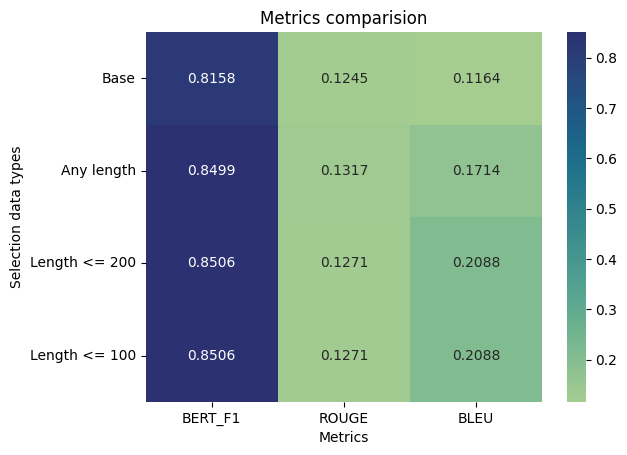

In [18]:
metrics_df = get_metric_table()
ax = sns.heatmap(metrics_df, annot=True, fmt='.4f', cmap="crest")
ax.set(xlabel="Metrics", ylabel="Selection data types", title='Metrics comparision')
ax.plot()

## Зависимости в данных

### Корреляция между длиной ответа и длиной вопроса

In [131]:
print(
    f"Correlation original answer: "
    + str(
        base_eval_table["len_of_question"].corr(
            base_eval_table["len_of_original_answer"]
        )
    )
)
print(
    f"Correlation for base model: "
    + str(
        base_eval_table["len_of_question"].corr(
            base_eval_table["len_of_generated_answer"]
        )
    )
)
print(
    f"Correlation for tuned model: "
    + str(
        tuned_eval_table["len_of_question"].corr(
            tuned_eval_table["len_of_generated_answer"]
        )
    )
)

Correlation original answer: 0.2809995796375293
Correlation for base model: 0.1465737020159977
Correlation for tuned model: 0.3547443572695564


### Кластеризация ответов

In [132]:
original_ans = base_eval_table.original_answer.values
base_gen_ans = base_eval_table.generated_answer.values
tuned_gen_ans = tuned_eval_table.generated_answer.values

#### Вспомогательные функции

In [133]:
def clustering(text_array, viz_type="PCA", num_clusters=5, title_name=None):

    # ____Tokenization and stemming____

    # create steam and tokenized voucabularies
    totalvocab_stemmed = []
    totalvocab_tokenized = []

    for i in text_array:
        allwords_stemmed = tokenize_and_stem(i)
        totalvocab_stemmed.extend(allwords_stemmed)

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame(
        {"words": totalvocab_tokenized}, index=totalvocab_stemmed
    )
    print("there are " + str(vocab_frame.shape[0]) + " items in vocab_frame")
    print()

    # ____Vectorization____
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.8,
        max_features=200000,
        min_df=0.05,
        stop_words="english",
        use_idf=True,
        tokenizer=tokenize_and_stem,
        ngram_range=(1, 3),
    )

    tfidf_matrix = tfidf_vectorizer.fit_transform(ans)
    print("Td idf Matrix shape: ", tfidf_matrix.shape)
    print()

    terms = tfidf_vectorizer.get_feature_names()

    # calculate the distance matrix . I will use them in the visualization of the cluster.
    dist = 1 - cosine_similarity(tfidf_matrix)

    # ____Clustering____ (K-means)
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_matrix)

    clusters = km.labels_.tolist()

    items = {"orig_ans": ans}

    frame = pd.DataFrame(items, index=[clusters], columns=["cluster"])

    print("Top terms per cluster:")

    # sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    for i in range(num_clusters):
        print("Cluster %d words:" % i, end="")

        for ind in order_centroids[i, :6]:  # replace 6 with n words per cluster
            print(
                " %s" % vocab_frame.loc[terms[ind].split(" ")].values.tolist()[0][0],
                end=",",
            )

        print()

    # ____Visualization____
    if viz_type == "PCA":
        pca = PCA(n_components=2)
        pos = pca.fit_transform(dist)

    elif viz_type == "TSNE":
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        # dist is the distance matrix
        pos = tsne.fit_transform(dist)

    xs, ys = pos[:, 0], pos[:, 1]
    cluster_names = {}
    cluster_n = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

    for i in range(num_clusters):
        cluster_names[i] = cluster_n[i]

    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))

    groups = df.groupby("label")

    fig, ax = plt.subplots(figsize=(16, 8))

    for name, group in groups:
        ax.plot(
            group.x,
            group.y,
            marker="o",
            linestyle="",
            ms=12,
            label=cluster_names[name],
            mec="none",
        )

    ax.legend(numpoints=1)
    plt.title(f"{title_name}")
    plt.show()

In [134]:
def tokenize_and_stem(text):

    stemmer = SnowballStemmer("english")

    # tokenize
    tokens = [
        word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)
    ]
    filtered_tokens = []

    # keep only letters
    for token in tokens:
        if re.search("[a-zA-Z]", token):
            filtered_tokens.append(token)
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):

    tokens = [
        word.lower()
        for sent in nltk.sent_tokenize(text)
        for word in nltk.word_tokenize(sent)
    ]
    filtered_tokens = []

    for token in tokens:
        if re.search("[a-zA-Z]", token):
            filtered_tokens.append(token)
    return filtered_tokens

#### Кластеризация

there are 19128 items in vocab_frame

Td idf Matrix shape:  (251, 113)

Top terms per cluster:
Cluster 0 words: work, just, function, way, window, yes,
Cluster 1 words: use, n't, 's, need, number, like,
Cluster 2 words: python, script, environments, use, run, modules,
Cluster 3 words: file, n't, data, write, use, read,
Cluster 4 words: install, packages, version, python, project, libraries,


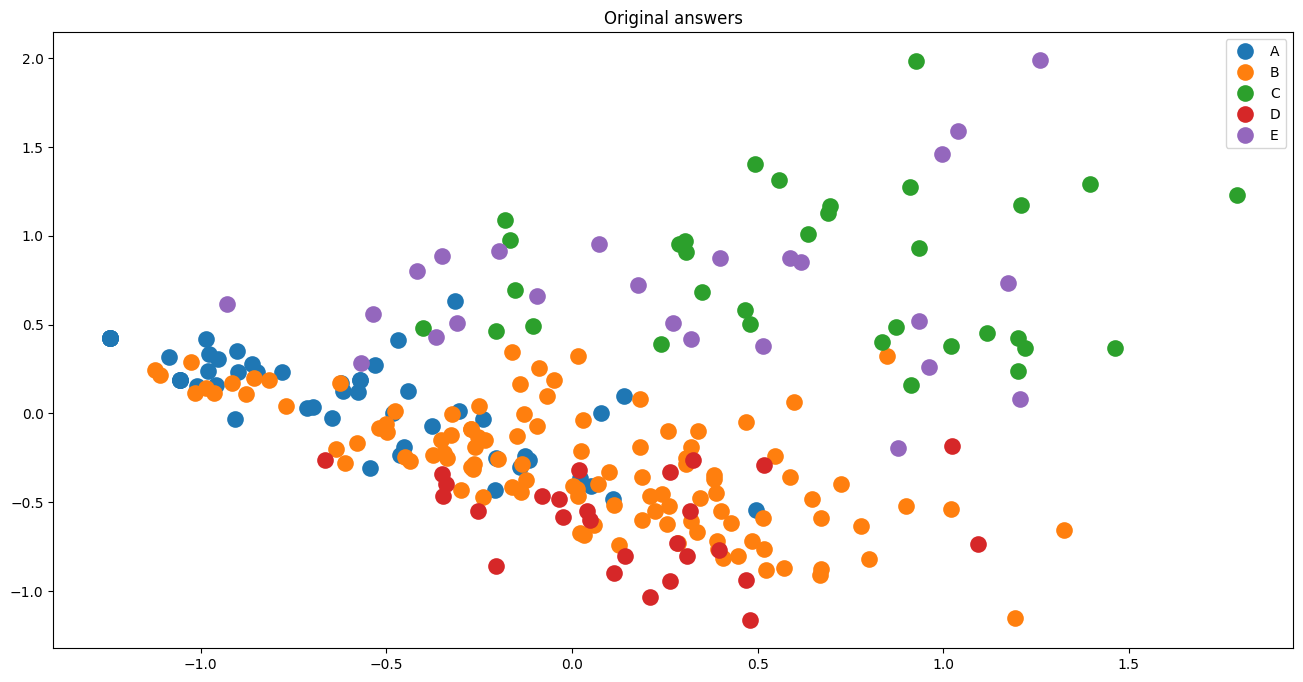

In [135]:
ans = original_ans
clustering(ans, title_name="Original answers")

there are 16341 items in vocab_frame

Td idf Matrix shape:  (251, 78)

Top terms per cluster:
Cluster 0 words: yes, possible, data, use, need, answer,
Cluster 1 words: use, think, data, functions, n't, object,
Cluster 2 words: print, x, return, file, def, use,
Cluster 3 words: installed, python, version, pip, packages, command,
Cluster 4 words: import, print, sys, use, module, think,


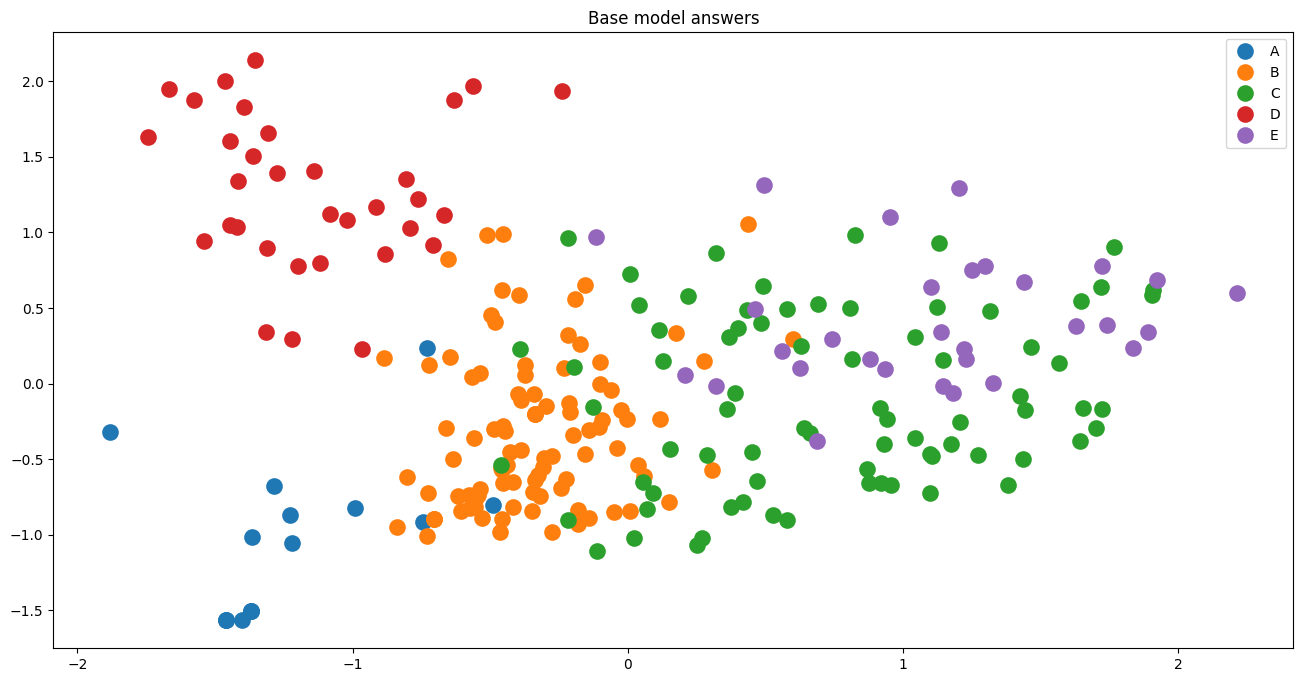

In [136]:
ans = base_gen_ans
clustering(ans, title_name="Base model answers")

there are 8481 items in vocab_frame

Td idf Matrix shape:  (251, 38)

Top terms per cluster:
Cluster 0 words: n't, ca, ca, only, running, use,
Cluster 1 words: use, think, number, way, list, libraries,
Cluster 2 words: 's, files, use, problem, string, code,
Cluster 3 words: following, code, use, use, commands, number,
Cluster 4 words: installed, package, pip, libraries, use, python,


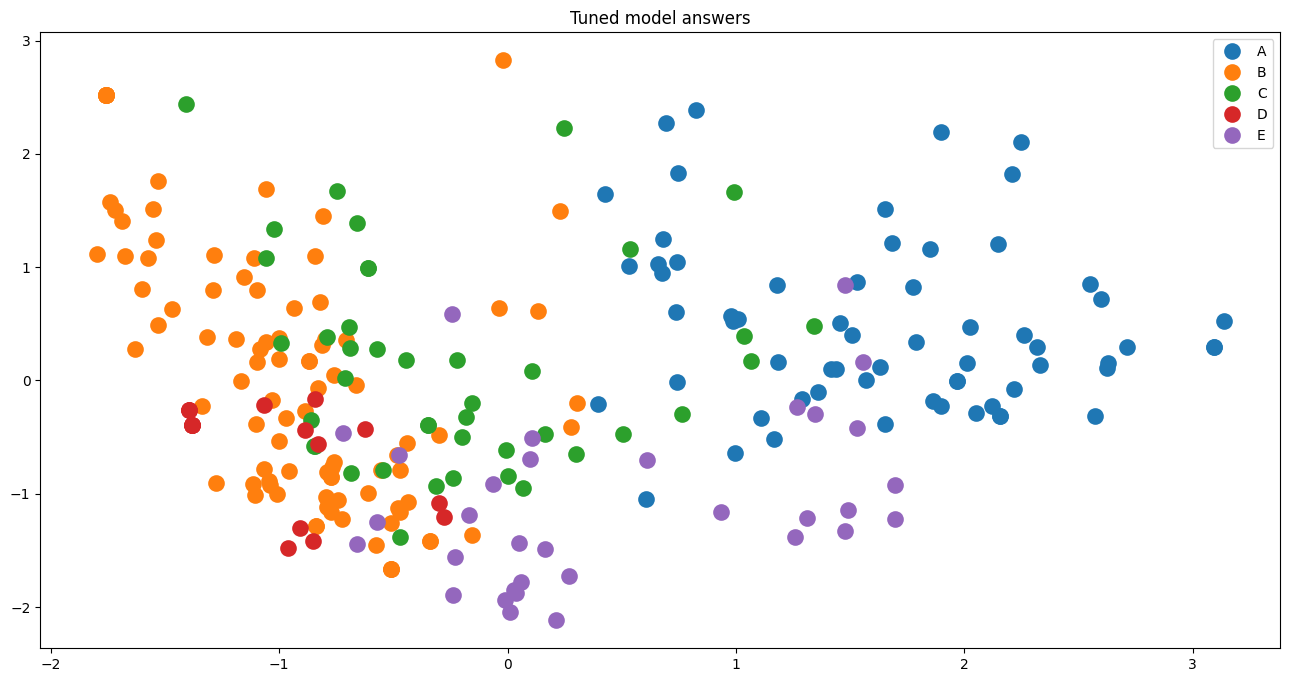

In [138]:
ans = tuned_gen_ans
clustering(ans, title_name="Tuned model answers")